In [1]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import math
import datetime

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

## Importing dataset:

In [2]:
MMSI636092331 = pd.read_csv(r"MMSI636092331.csv")
MMSI636092331

,mmsi,lat,long,sog,rot,cog,datetimestamp
0,636092331,-4.767917,48.766190,12.2,15,61.0,2016-03-03 10:58:24
1,636092331,-4.835128,48.742413,13.1,-27,68.5,2016-03-03 10:43:54
2,636092331,-4.835327,48.742360,12.8,-29,68.3,2016-03-03 10:43:53
3,636092331,-4.835595,48.742290,12.4,-37,67.1,2016-03-03 10:43:48
4,636092331,-4.836520,48.742012,12.8,-19,61.4,2016-03-03 10:43:38
...,...,...,...,...,...,...,...
6245,636092331,-5.127655,48.122654,13.3,28,76.4,2016-03-02 04:53:52
6246,636092331,-5.128298,48.122547,13.1,36,74.6,2016-03-02 04:53:46
6247,636092331,-5.128785,48.122480,13.6,-14,71.4,2016-03-02 04:53:40
6248,636092331,-5.129277,48.122353,13.8,34,72.9,2016-03-02 04:53:34


# Converting types:

In [3]:
MMSI636092331['datetimestamp'] = pd.to_datetime(MMSI636092331['datetimestamp'])
#MMSI636092331.sort('datetimestamp')
df_sorted = copy.deepcopy(MMSI636092331.sort_values(by = 'datetimestamp', ascending = True ))


myresult = df_sorted['datetimestamp'] -pd.to_datetime('2016-03-02 03:33:34')
myresult.dt.total_seconds()



df_sorted['datetimestamp'] = pd.DataFrame(myresult.dt.total_seconds())
#print(df_sorted.head())



In [4]:
def convert_cog(data_in):
    return data_in*np.pi/180 #convert to radians

In [5]:
def convert_rot(data_in):
    return (data_in/60)*np.pi/180 #rad per second
    

In [6]:
def convert_sog(data_in):
    return data_in*0.5144444444 #meter per second

In [123]:
def convert_XY(data_in):
    #constants:
    a = 6378137.0
    b = 6356752.3
    
    lat = data_in['lat']
    long = data_in['long']
    def calc_N(a,b,lat):
        e = (a**2 -b**2)/a**2
        return a*(np.sqrt(1-e*np.sin(lat)**2))
    h = 0
    N = calc_N(a,b,lat)
    X = (N+h)*np.cos(lat)*np.cos(long)
    Y = (N+h)*np.cos(lat)*np.sin(long)
    
    return X, Y

In [128]:
def convert_dataset(data_in):
    #Converting time date:
    df_sorted = copy.deepcopy(data_in.sort_values(by = 'datetimestamp', ascending = True ))
    first_obs_date = df_sorted.iloc[0,6]
    
    #Calculating the time difference in seconds
    time_from_zero_sec = (df_sorted['datetimestamp'] -pd.to_datetime(first_obs_date)).dt.total_seconds()
    df_sorted['datetimestamp'] = pd.DataFrame(time_from_zero_sec)

    #Conversion of Course over ground
    df_sorted['cog'] = convert_cog(df_sorted['cog'])
    
    #Convert Speed over ground to mps
    df_sorted['sog'] = convert_sog(df_sorted['sog'])
    
    #Convert rate of turn 
    df_sorted['rot'] = convert_rot(df_sorted['rot'])
    
    #Making the order same as testset
    
    df_sorted = df_sorted[['datetimestamp', 'lat', 'long', 'cog', 'sog','rot']]
    
    #Adding delta time and updating the order again
    delta_time = [0]
    for i in range(1, len(df_sorted['datetimestamp'])):
        delta_time.append(int(df_sorted['datetimestamp'][i-1]-df_sorted['datetimestamp'][i]))
        
    df_sorted.insert(1,'deltatime',delta_time ) #adding the delta time row
    
    
    #Convert Coordinates
    X, Y = convert_XY(data_in)
    data_in['lat'] = X
    data_in['long'] = Y
    
    

   
    return df_sorted
    
    

In [129]:
def discrete_subsample_data(data_in, eachObs = 10):
    sub_script = np.arange(0,len(data_in),eachObs)
    return data_in.iloc[sub_script,:]
    
    

In [130]:
pd_final=  copy.deepcopy(convert_dataset(MMSI636092331).reset_index(drop = True))
print(pd_final)

      datetimestamp  deltatime           lat          long       cog  \
0               0.0          0 -3.009752e+06 -3.598498e+06  1.146681   
1               0.0        870 -3.009752e+06 -3.598498e+06  1.146681   
2             911.0          1 -2.706044e+06 -3.396519e+06  1.162389   
3             911.0          5 -2.706044e+06 -3.396519e+06  1.162389   
4            1515.0         10 -2.498368e+06 -3.240373e+06  1.117011   
...             ...        ...           ...           ...       ...   
6245       112219.0         10  3.715043e+04 -7.786714e+05  1.192060   
6246       112220.0          6  3.713197e+04 -7.774190e+05  1.195551   
6247       112220.0          6  3.713197e+04 -7.774190e+05  1.195551   
6248       113090.0          6  2.520495e+04 -3.518967e+05  1.064651   
6249       113090.0          6  2.520495e+04 -3.518967e+05  1.064651   

           sog       rot  
0     6.996444 -0.002327  
1     6.996444 -0.002327  
2     7.150778  0.006690  
3     7.150778  0.006690  


# Testing Kalman

In [131]:
def deg_to_rad(deg):
    return deg*np.pi/180

def rad_to_deg(rad):
    return rad*180/np.pi

def get_mat_A(deltaTime):
    A = np.identity(4)
    A[0,2] = deltaTime
    A[1,3] = deltaTime
    return A

def predict_state(A, X_prev, a_x, a_y, deltaTIME):
        
    Bu_k = np.array([[a_x*deltaTIME*deltaTIME/2],
                     [a_y*deltaTIME*deltaTIME/2],
                     [a_x*deltaTIME],
                     [a_y*deltaTIME]])
    
    pred_state = A.dot(X_prev) + Bu_k
    return pred_state

def pred_err_cov(A, Pk, Q):
    return A.dot(Pk).dot(np.transpose(A)) + Q

def Kalman_gain(P_k, H, R):
    above = P_k.dot(np.transpose(H))
    bottom = np.linalg.inv(H.dot(P_k).dot(np.transpose(H)) + R)
    return above.dot(bottom)

def adjust_pred_state(pred_state, Kk,z_k,H):
    #Where z_k == the real observed value to adjust for the errors made
    return pred_state + Kk.dot(z_k - H.dot(pred_state))

def update_err_cov(I,Kk,H,P_k):
    return (I - Kk.dot(H)).dot(P_k)    

def calc_a_xy(arr_in, arr_prev):
    
    sog_now = arr_in[5]
    sog_prev = arr_prev[5]
    
    cog_now = arr_in[4]*np.pi/180
    cog_prev = arr_prev[4]*np.pi/180
    
    rot_now = arr_in[6]*np.pi/180
    
    delta_time = arr_in[1]
    
    a_x = (sog_now*np.cos(cog_now + rot_now*delta_time) - sog_prev*np.cos(cog_prev))/delta_time
    
    a_y = (sog_now*np.sin(cog_now + rot_now*delta_time) - sog_prev*np.sin(cog_prev))/delta_time 
    
    return a_x, a_y
    

In [132]:
def convert_state(arr_in):
    sog = arr_in[5]
    cog = arr_in[4]
    
    x = arr_in[2]
    y = arr_in[3]
    Vx = sog*np.cos(deg_to_rad(cog))
    Vy = sog*np.sin(deg_to_rad(cog))
    
    return_arr = np.array([[x],[y],[Vx],[Vy]])
    
    return return_arr

In [133]:
def extract_long_lat_covariance(mat_in):
    Var1 = mat_in[0,0]
    Var2 = mat_in[1,1]
    Cov12 = mat_in[0,1]
    
    result = np.array([[Var1,Cov12],[Cov12,Var2]])
    return result

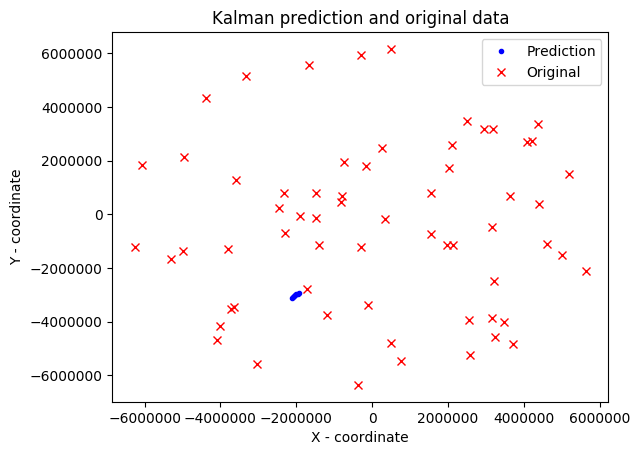

In [137]:
# Declaring the constants for Kalman filter:
pd_final=  copy.deepcopy(convert_dataset(MMSI636092331).reset_index(drop = True))

pd_final = discrete_subsample_data(pd_final,100)

#print(pd_final)

A = get_mat_A(1)
P_k = np.array([[1000],[1000],[0.5],[0.5]]).dot(np.transpose(np.array([[100],[10],[0.5],[0.5]])))
H = np.identity(4)
I = np.identity(4)


# Sensitivity measures, deep copy to avoid address pointers:
R = np.diag(np.array([5,5,-0.8,-0.8]))
R = np.diag(np.array([2000,2000,0.3,0.3]))

Q = copy.deepcopy(P_k)

# Kalman Initial state
X_state = np.array([[0],[0],[0],[0]])
ax_arr = []
ay_arr = []

X_save_states = []
Pk_save_states = []
Pk_save_states.append(copy.deepcopy(P_k))

polish_counter = 1 # counter for the original data set obsevations

max_time = int(max(pd_final.iloc[:,0]))
for i in range(0,(max_time)):
    
   
    '''If we observe the value we observe this'''
    if(i == 0 or (pd_final.iloc[polish_counter,0] == i and polish_counter < max_time)):
        zk_prev = pd_final.iloc[polish_counter-1,:].values
        z_k = pd_final.iloc[polish_counter,:].values # convert to numpy array -observed value
        
        delta_TIME = copy.deepcopy(z_k[1])
       # print("WERK DIE" ,delta_TIME)
            
        ax, ay = calc_a_xy(z_k,zk_prev)
        ax_arr.append(ax)
        ay_arr.append(ay)
        
        z_k = copy.deepcopy(convert_state(z_k))
       
        X_state = copy.deepcopy(convert_state(zk_prev))
        #Kalman Predict        
        X_state = copy.deepcopy(predict_state(A, X_state, ax, ay, 1))
        P_k =  copy.deepcopy(pred_err_cov(A, P_k, Q))
        
        # Measuremenet update
        Kalman_k = copy.deepcopy(Kalman_gain(P_k, H, R))
        X_state = copy.deepcopy(adjust_pred_state(X_state, Kalman_k, z_k, H))
        P_k = copy.deepcopy(update_err_cov(I, Kalman_k, H, P_k))
        
        X_save_states.append(copy.deepcopy(X_state))
        
        polish_counter += 1
        Pk_save_states.append(copy.deepcopy(P_k))
        #print(z_k, '\n')
    else:
        '''This code will be excecuted when we have no observation'''
        ay = 0
        ax = 0
        X_state = copy.deepcopy(predict_state(A, X_state, ax, ay, 1))
        P_k =  copy.deepcopy(pred_err_cov(A,P_k,Q))
        Pk_save_states.append(copy.deepcopy(P_k))
        X_save_states.append(copy.deepcopy(X_state))

        
        

# Saving the coordinates:
X_coord = []
Y_coord = []
Pk_coord  = []

X_orig = pd_final.iloc[:,2]
Y_orig = pd_final.iloc[:,3]

for i in range(0,len(pd_final)):
    if  i % 10 == 0:
        X_coord.append(X_save_states[i][0][0])
        #print(X_save_states[i][0][0])
        Y_coord.append(X_save_states[i][1][0])
        Pk_coord.append(extract_long_lat_covariance(Pk_save_states[i]))

    
#plt.plot(X_coord[11:380], Y_coord[11:380], "bx")
plt.plot(Y_coord,X_coord, "b.")
plt.plot(Y_orig,X_orig, "rx")
plt.title("Kalman prediction and original data")
plt.xlabel("X - coordinate")
plt.ylabel("Y - coordinate")
legend_data = np.array(["Prediction","Original"])
plt.legend(legend_data, loc = "best")

plt.show()
    

In [135]:
print(max(pd_final.iloc[:,0]))

91712.0


In [136]:
X_plot = []
Y_plot = []

for i in subscript:
    X_plot.append(X_orig[i])
    Y_plot.append(Y_orig[i])

plt.plot(X_orig,Y_orig, "r.")
plt.show()



KeyError: 105

In [70]:
df_sorted

,mmsi,lat,long,sog,rot,cog,datetimestamp
1373,636092331,-5.540490,47.998146,13.6,-8,65.7,0.0
686,636092331,-5.540490,47.998146,13.6,-8,65.7,0.0
1372,636092331,-5.463012,48.021954,13.9,23,66.6,911.0
685,636092331,-5.463012,48.021954,13.9,23,66.6,911.0
1371,636092331,-5.410512,48.037872,13.8,11,64.0,1515.0
...,...,...,...,...,...,...,...
2,636092331,-4.835327,48.742360,12.8,-29,68.3,112219.0
1,636092331,-4.835128,48.742413,13.1,-27,68.5,112220.0
688,636092331,-4.835128,48.742413,13.1,-27,68.5,112220.0
687,636092331,-4.767917,48.766190,12.2,15,61.0,113090.0
